<a href="https://colab.research.google.com/github/33quitykubby/SIGNATE_Practice/blob/main/SGN_Casting_20210912_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **【練習問題】鋳造製品の欠陥検出**  
https://signate.jp/competitions/406/data

---

Pytorchを使った2値分類  
モデル：EfficientNet B0

ヒートマップを追加してみた(9/12)

参考  
https://axa.biopapyrus.jp/deep-learning/pytorch/simple-cnn-classification.html

Pytorch全体  
https://qiita.com/wataoka/items/c72261bae7d7ef300e29


Dataloader  
https://pystyle.info/pytorch-how-to-create-custom-dataset-class/  
https://qiita.com/kumonk/items/0f3cad018cc9aec67a63

交差検証  
https://qiita.com/ground0state/items/ad879a84bf946ef94da8  

学習  
https://hntk03.hatenablog.com/entry/2019/08/27/112435

コンペ：prob space 宗教画テーマの分類  
トピック EfficientNetB0使ったベースライン紹介(skywalker氏)  
https://comp.probspace.com/competitions/religious_art/submissions\\

ヒートマップ

https://www.kaggle.com/debarshichanda/gradcam-visualize-your-cnn#notebook-container

https://deepblue-ts.co.jp/image-processing/pytorch_gradcam_cnnvgg16/

# マウント

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setting

In [58]:
!nvidia-smi

Sun Sep 12 15:14:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    71W / 149W |   3475MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
# !pip uninstall albumentations -y
# !pip install albumentations==0.4.5 -q
!pip install albumentations==0.5.0 -q

In [60]:
!pip install timm -q

# パス指定

In [61]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/'

OUTPUT_DIR = '/content/drive/Othercomputers/myPC/GoogleDrive/OutputFile/Signate_Casting/'


# **import**

In [62]:
import warnings
warnings.simplefilter('ignore')
import os
import gc
gc.enable()
import sys
import glob
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import GroupKFold, StratifiedKFold
from datetime import datetime
from tqdm.autonotebook import tqdm as tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import roc_auc_score
import timm

import datetime

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path

In [63]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

#終了時刻
time_of_begin = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))

Sun Sep 12 15:14:51 JST 2021


# 乱数シード固定

In [64]:
def seed_everything(seed:int==42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(32)

# データ読み込み

## MyDataset(未使用)

In [65]:
import torchvision.transforms as transforms

class MyDataset(torch.utils.data.Dataset):

  def __init__(self, imageSize, dir_path, transform=None):
    self.transforms = transforms.Compose([
                                          transforms.Resize(imageSize),
                                          transforms.ToTensor(),
    ])

    train_data_dir = dir_path + "train_data/"
    self.image_paths = [str(p) for p in Path(train_data_dir).glob("*.jpeg")]
    self.data_num = len(self.image_paths) #lenの返り値

    # ラベル用のデータ読み込み
    self.train_labels = pd.read_csv(dir_path + "train.csv", index_col='id')

  def __len__(self):
    return self.data_num

  def __getitem__(self, idx):
    p = self.image_paths[idx]
    image = Image.open(p)

    print(p)

    if self.transform:
      out_data = self.transform(image)

    #ラベル取り出し
    str_p = p.rsplit('/', 1)[1]    
    label = self.train_labels['target'][str_p]

    return out_data, out_label


## TrainDataset

---

**学習データを読み出して渡すクラス**  
\_\_len__：  
>一回のデータ取得に対して返すデータの数  >交差検証の場合は、1Fold分のデータ数になる

\_\_getitem__：  
>1. 交差検証であらかじめ分割されたインデックスを引数でわたし、該当するデータをファイルから読みだす。  
2. 読みだしたデータをndarrayに変換（transformでalbumentationsを使っているので必要）  
3. transformで変換してreturn  

※以下はalbumentationsで必要な処理

    img = self.transform(image=image)

    return {
            'image' : torch.tensor(out_data, dtype=torch.float),
            'target' : torch.tensor(out_label, dtype=torch.float).long(),}

In [66]:
import torchvision.transforms as transforms

class TrainDataset(torch.utils.data.Dataset):

  def __init__(self, imageSize, dir_path, index, transform=None):
    self.transform = A.Compose([
                                          A.Resize(imageSize,imageSize),
                                          A.VerticalFlip(p=0.5),
                                          A.HorizontalFlip(p=0.5),
                                          # A.Normalize(),
                                          ToTensorV2(),
    ])

    train_data_dir = dir_path + "train_data/"
    self.image_paths = [str(p) for p in Path(train_data_dir).glob("*.jpeg")]

    self.index = index
    # print(index[1])
    # print(index[249])

    self.data_num = len(self.index) #lenの返り値

    # ラベル用のデータ読み込み
    self.train_labels = pd.read_csv(dir_path + "train.csv", index_col='id')

  def __len__(self):
    return self.data_num

  def __getitem__(self, idx):
    current_index = self.index[idx]
    # print(idx)
    # print(current_index)

    p = self.image_paths[current_index]
    image = Image.open(p)
    image = np.array(image)

    img = self.transform(image=image)
    out_data = img['image']

    #ラベル取り出し
    str_p = p.rsplit('/', 1)[1]    
    out_label = self.train_labels['target'][str_p]

    return {
            'image' : torch.tensor(out_data, dtype=torch.float),
            'target' : torch.tensor(out_label, dtype=torch.float).long(),}


## TestDataset

---

**テストデータを読み出して渡すクラス**  
TrainDatasetとの違いはaubmentationsによるデータ拡張をResizeとToTensorに限定している事

In [67]:
class TestDataset(torch.utils.data.Dataset):

  def __init__(self, imageSize, dir_path, transform=None):
    self.transform = A.Compose([
                                          A.Resize(imageSize,imageSize),
                                          # A.Normalize(),
                                          ToTensorV2(),
    ])


    train_data_dir = dir_path + "test_data/"
    self.image_paths = [str(p) for p in Path(train_data_dir).glob("*.jpeg")]

    self.data_num = len(self.image_paths) #lenの返り値

  def __len__(self):
    return self.data_num

  def __getitem__(self, idx):
    # print(self.image_paths[idx])
    p = self.image_paths[idx]
    image = Image.open(p)
    image = np.array(image)

    img = self.transform(image=image)
    out_data = img['image']

    return {
            'image' : torch.tensor(out_data, dtype=torch.float),}


# 全データ取得

In [68]:
train_labels = pd.read_csv(BASE_PATH + "train.csv", index_col='id')

print(train_labels.shape)
train_labels

(250, 1)


,target
id,
cast_def_0_335.jpeg,0
cast_def_0_323.jpeg,0
cast_def_0_61.jpeg,0
cast_def_0_163.jpeg,0
cast_def_0_175.jpeg,0
...,...
cast_ok_0_346.jpeg,1
cast_ok_0_307.jpeg,1
cast_ok_0_242.jpeg,1


# Model

---

モデル定義  
"efficientnet_b0"を採用  
https://qiita.com/omiita/items/83643f78baabfa210ab1  
https://zenn.dev/kleamp1e/articles/202104-efficientnet




以下で最終層を2クラス分類のLinear層（全結合層）に変換  
それ以外はそのまま利用

```
self.n_features = self.modelbase.classifier.in_features
self.modelbase.classifier = nn.Linear(self.n_features, CLASSES)
```


In [69]:
# モデル
MODEL_DEFINE = 'efficientnet_b0'

# 入力画像サイズ
INPUT_IMAGE_SIZE = 224

# クラス
CLASSES = 2

# エポック
EPOCHS = 10


In [70]:
class Model(nn.Module):    
    def __init__(self, pretrained=False):
        super().__init__()
        self.modelbase = timm.create_model(MODEL_DEFINE, 
                                          pretrained=pretrained,
                                          in_chans=3)        
        self.n_features = self.modelbase.classifier.in_features
        self.modelbase.classifier = nn.Linear(self.n_features, CLASSES)

    def forward(self, x):
        output = self.modelbase(x)
        output = Func.log_softmax(output, dim = 1)
        return output


In [71]:
momdel = Model()

# model

# 学習

In [72]:
# 学習率
LEARNING_RATE = 1e-3

# 減衰率
WEIGHT_DECAY = 1e-5

# GPU/CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ベストケースのモデル情報の格納場所
MODEL_DIR = BASE_PATH + "model_data/"

# fold数
FOLDS = 3

## 学習関数

---

学習のtrainのための関数  
DataLoaderから所定の数だけデータをバッチサイズ分取り出してimage,labelに分割  


In [73]:
def func_train(model, device, optimizer, loss_function, train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for batch_idx,  train in enumerate(train_loader):
        images = train['image'].to(device)
        labels = train['target'].to(device)
        
        optimizer.zero_grad() 
        preds = model(images)
        
        loss = loss_function(preds, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    
    return train_loss

## valid関数

---

学習のvalidationのための関数  
train時とちがって順伝播してlossを計算するだけの関数

In [74]:

def func_valid(model, device, loss_function, dataloader ):    
    model.eval()
    running_loss = 0
    test_preds = []

    for batch_idx, valid in enumerate(dataloader):
        images = valid['image'].to(device)
        labels = valid['target'].to(device)
        preds = model(images)     
        
        loss = loss_function(preds, labels) 
        running_loss += loss.item()

    valid_loss = running_loss / len(dataloader)   
    return valid_loss

## テスト関数
---
テスト用の関数なのでラベルが無い

In [75]:

def func_test(model, device, dataloader ):    
    model.eval()        
    final_loss = 0
    test_preds = []

    for step, test in enumerate(dataloader):
        print("stap=",step)    
        images = test['image'].to(device)
        preds = model(images)            
        test_preds.append(preds.sigmoid().detach().cpu().numpy())                
    
    test_preds = np.concatenate(test_preds)    
    return test_preds

## foldごとの関数

---

kFoldでインデックスを3等分  
各Foldごとにtrainとvalidationを行い、最小のlossになったモデルを保存しておく  
epoch数分の処理が完了したらpred値をFold数で割って加算していく

In [76]:
# kf = StratifiedKFold(n_splits=3)
from sklearn.model_selection import KFold


kf = KFold(n_splits=FOLDS, shuffle=True)
batch_size = 16


# テストデータの数を知りたい
dir = BASE_PATH + "test_data/"
test_len = sum(os.path.isfile(os.path.join(dir,name)) for name in os.listdir(dir))

# pred初期化
pred = np.zeros((test_len, CLASSES))

cv = 0
for _fold, (train_index, valid_index) in enumerate(kf.split(train_labels)):
  # print(train_index)
  # print(valid_index)  

  # loss最小値の初期化(とりあえず100)
  min_loss = 100


  train_dataset = TrainDataset(INPUT_IMAGE_SIZE, dir_path=BASE_PATH, index = train_index)
  train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

  valid_dataset = TrainDataset(INPUT_IMAGE_SIZE, dir_path=BASE_PATH, index = valid_index)
  valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False)

  model = Model(pretrained=True)
  model.to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(),
                                lr=LEARNING_RATE,
                                weight_decay=WEIGHT_DECAY)
  
  loss_function = nn.CrossEntropyLoss()

  start_time = time.time()
  end_time = start_time

  # 学習
  # EPOCHS = 2 # for test
  for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss = func_train(model, DEVICE, optimizer, loss_function, train_dataloader)
    valid_loss = func_valid(model, DEVICE, loss_function, valid_dataloader)

    if valid_loss < min_loss:
        min_loss = valid_loss            
        MODEL_PATH = f"{MODEL_DIR}best_{MODEL_DEFINE}_fold{_fold+1}.pth"
        torch.save(model.state_dict(), MODEL_PATH)

    end_time = time.time()
    print(f"FOLD: {_fold+1} | EPOCH:{epoch+1:02d} | train_loss:{train_loss:.6f} | valid_loss:{valid_loss:.6f} | time:{end_time-start_time:.1f}s ")

  print("final valid_loss : ",valid_loss )

  model.load_state_dict(torch.load(MODEL_PATH))
  test_dataset = TestDataset(INPUT_IMAGE_SIZE, dir_path=BASE_PATH)
  test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

  pred_list = func_test(model, DEVICE, test_dataloader)

  # print(pred_list)

  pred += pred_list/FOLDS


FOLD: 1 | EPOCH:01 | train_loss:0.338954 | valid_loss:5.809814 | time:3.9s 
FOLD: 1 | EPOCH:02 | train_loss:0.149996 | valid_loss:0.220210 | time:3.8s 
FOLD: 1 | EPOCH:03 | train_loss:0.237187 | valid_loss:0.040695 | time:3.8s 
FOLD: 1 | EPOCH:04 | train_loss:0.056229 | valid_loss:0.008094 | time:3.8s 
FOLD: 1 | EPOCH:05 | train_loss:0.041063 | valid_loss:0.009215 | time:3.7s 
FOLD: 1 | EPOCH:06 | train_loss:0.085988 | valid_loss:0.006400 | time:3.8s 
FOLD: 1 | EPOCH:07 | train_loss:0.049187 | valid_loss:0.008234 | time:3.7s 
FOLD: 1 | EPOCH:08 | train_loss:0.106863 | valid_loss:0.149990 | time:3.8s 
FOLD: 1 | EPOCH:09 | train_loss:0.047463 | valid_loss:0.044035 | time:3.7s 
FOLD: 1 | EPOCH:10 | train_loss:0.027809 | valid_loss:0.034337 | time:3.7s 
final valid_loss :  0.03433666851681968
stap= 0
stap= 1
stap= 2
stap= 3
stap= 4
stap= 5
stap= 6
FOLD: 2 | EPOCH:01 | train_loss:0.319113 | valid_loss:1.842530 | time:3.8s 
FOLD: 2 | EPOCH:02 | train_loss:0.140810 | valid_loss:0.455340 | tim

# ヒートマップ
---
https://qiita.com/bamboo-nova/items/082f71b96b9aca0d5df5

In [77]:
!pip install pytorch-gradcam

In [78]:
from torchvision.utils import make_grid, save_image

# Grad-CAM
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


# modelをロード
model = Model(pretrained=True)
model.to(DEVICE)

fold = 0 #for test
MODEL_PATH = f"{MODEL_DIR}best_{MODEL_DEFINE}_fold{_fold+1}.pth"
model.load_state_dict(torch.load(MODEL_PATH))

# Grad-CAM
target_layer = model.modelbase.blocks
gradcam = GradCAM(model, target_layer)
gradcam_pp = GradCAMpp(model, target_layer)

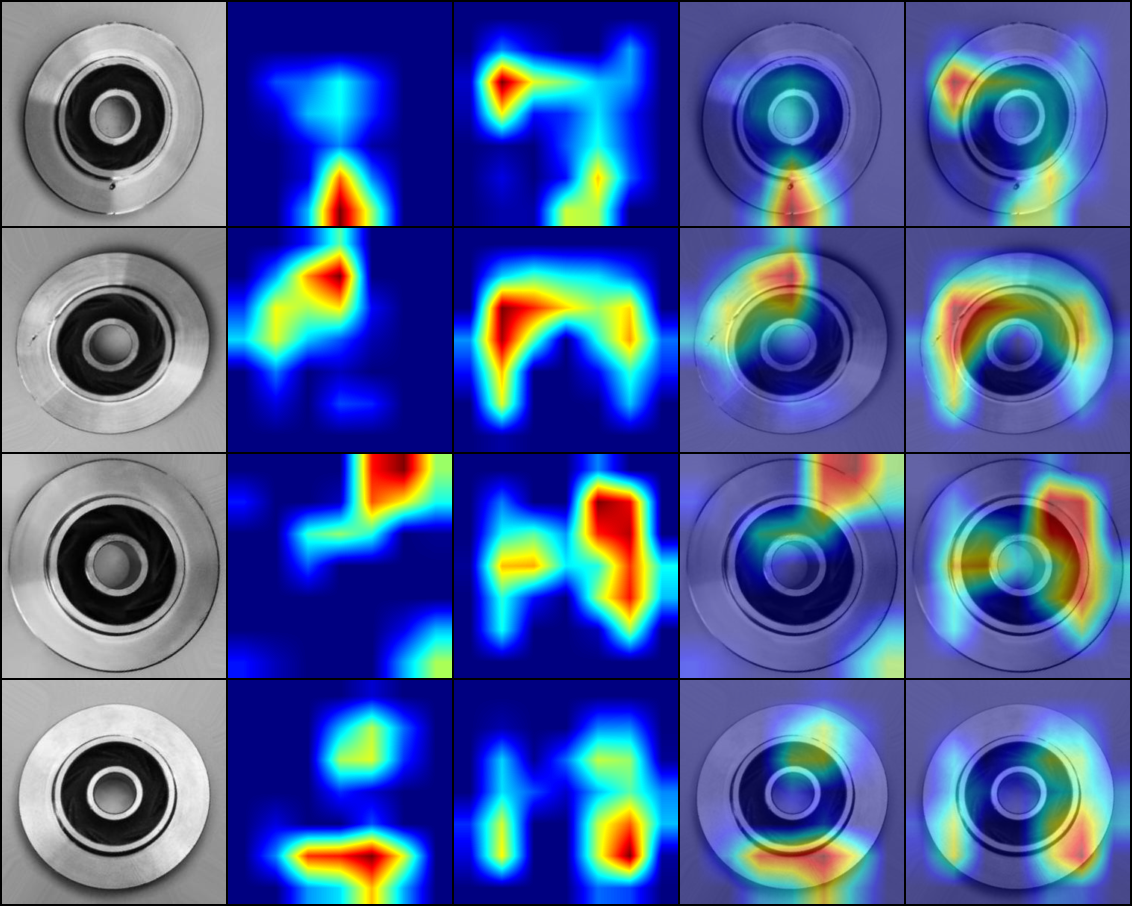

In [91]:
images = []
# あるラベルの検証用データセットを呼び出してる想定
DATAS_PATH = '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_partial'
for path in glob.glob(DATAS_PATH+"/*"):
    img = Image.open(path)
    torch_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])(img).to(DEVICE)
    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
grid_image = make_grid(images, nrow=5)

# 結果の表示
transforms.ToPILImage()(grid_image)


# 結果出力


## サンプルcsv読み込み

In [92]:
test_samples = pd.read_csv(BASE_PATH + "sample_submission.csv", header=None)

pred_df = test_samples.set_axis(['filename', 'y'], axis=1)

print(pred_df.shape)
pred_df


(100, 2)


,filename,y
0,19871.jpeg,0
1,29934.jpeg,0
2,39826.jpeg,0
3,49888.jpeg,0
4,59918.jpeg,0
...,...,...
95,969983.jpeg,0
96,979891.jpeg,0
97,989921.jpeg,0
98,999921.jpeg,0


## ファイル名をテストデータで入力している順にする
---

テストディレクトリの読み出し順にあわせて投稿データとする

In [93]:
test_data_dir = BASE_PATH + "test_data/"
test_image_paths = [str(p) for p in Path(test_data_dir).glob("*.jpeg")]

print(test_image_paths)

for i in range(len(test_image_paths)):
  test_image_paths[i] = test_image_paths[i].rsplit('/', 1)[1]

pred_df['filename'] = test_image_paths

pred_df

['/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/229958.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/559880.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/699970.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/609988.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/929917.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/89914.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/79963.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/779897.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/549992.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/709966.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/589947.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/949956.jpeg', '/content/drive/MyDrive/Colab Notebooks/SIGNATE_鋳造/test_data/269945.jpeg', '/content/drive/MyDrive/Co

,filename,y
0,229958.jpeg,0
1,559880.jpeg,0
2,699970.jpeg,0
3,609988.jpeg,0
4,929917.jpeg,0
...,...,...
95,819873.jpeg,0
96,769946.jpeg,0
97,59918.jpeg,0
98,189978.jpeg,0


## 学習結果をセット

In [94]:
pred_df['y'] = np.argmax(pred, axis=1).astype('int')

pred_df

,filename,y
0,229958.jpeg,0
1,559880.jpeg,0
2,699970.jpeg,0
3,609988.jpeg,0
4,929917.jpeg,0
...,...,...
95,819873.jpeg,1
96,769946.jpeg,1
97,59918.jpeg,1
98,189978.jpeg,1


In [95]:
for i in range(CLASSES):
    pred_df[f'pred_{i}'] = pred[:, i]

now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))

#詳細
str_detail_file = OUTPUT_DIR  + 'SGN_Casting_detail_EffB0_' +  now.strftime('%m%d%H%M') +'.csv'
pred_df.to_csv(str_detail_file, index=False)

str_file = OUTPUT_DIR  + 'SGN_Casting_submit__EffB0_' +  now.strftime('%m%d%H%M') +'.csv'
pred_df[['filename', 'y']].to_csv(str_file, header=False, index=False)

display(pred_df.head())

,filename,y,pred_0,pred_1
0,229958.jpeg,0,0.499976,0.000094
1,559880.jpeg,0,0.498910,0.004308
2,699970.jpeg,0,0.499948,0.000209
3,609988.jpeg,0,0.498744,0.004917
4,929917.jpeg,0,0.499750,0.000999


# 終わり

In [96]:
#終了時刻
time_of_finish = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",time_of_finish)
print("total_time=",time_of_finish-time_of_begin)

finish_time= 2021-09-12 15:23:40.566788+09:00
total_time= 0:08:48.781843
